### Train UNet

In this notebook a Group-UNet is trained

In [1]:
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
import random
from torch.utils.data import DataLoader
import pickle

# Add level above to path
sys.path.append('../')

# This is only done to fix environment error (see https://stackoverflow.com/questions/20554074/sklearn-omp-error-15-initializing-libiomp5md-dll-but-found-mk2iomp5md-dll-a)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Import library functions
import lib.models as m
from lib.utils import train, test, test_equivariance, visualize_test_equivariance
import datasets as d

if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We start by setting the random seeds and defining the DataLoaders

In [2]:
#Set seed
seed = 40
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:
# Set parameters for datasets
batch_size = 8
transform_train = [True,False] # First element is scaling/brightness second is rotation
transform_test = [False,False] # First element is scaling/brightness second is rotation

# Path to the dataset
data_path = "../datasets/data/Fundus_Retina/dataset_2000samples/"

trainset = d.FUNDUS_RETINA(dataset = "train", transform = transform_train, data_path=data_path)
valset = d.FUNDUS_RETINA(dataset = "val", transform = transform_test, data_path=data_path)
testset = d.FUNDUS_RETINA(dataset = "test", transform = transform_test, data_path=data_path)

In [4]:
# Get dataloaders
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Show images

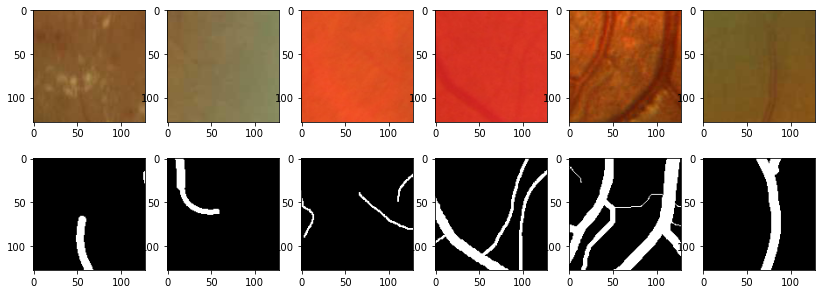

In [5]:
X,y = next(iter(test_loader))
    
# Show 6 or less images
N_imgs = X.shape[0] if X.shape[0] < 6 else 6
imgsize = N_imgs*3 if N_imgs*3 < 14 else 14

f,ax = plt.subplots(2,N_imgs,figsize=(imgsize,5))
ax = ax.flatten()
for i in range(N_imgs):
    ax[i].imshow(np.moveaxis(X[i].numpy(),0,2))
    ax[i+N_imgs].imshow(y[i,0].numpy(),'gray')
plt.show()

### Set Configs for run

We can define a G-UNet just like a normal UNet, we need only specify the group it belongs to and whether there should be a mask for equivariance.
The **equvariant_mask** removes from an input image all the parts of the image defined on the pixels which lay outside the circle inscribed in the grid of the image size. This ensures rotation equivariance. For segmentations this will naturally yield a worse segmentation, since some parts of the image is removed, so in this case we set it to **False**. <br>
The **group** is which rotation group this network should belong to, currently the options are: *C4*, *C8*, *D4*, and *D8*.


In [6]:
config = {
    'epochs': 20,                   # Number of epochs to run
    'batch_size': batch_size,       # Batch size
    'learning_rate': 1e-2,          # Learning rate
    'optimizer': 'adam',            # Optimizer
    'step_lr': [True, 5, 0.1],      # Step learning rate patience and decrease param
    'early_stopping' : 5,           # Early stopping patience
    'loss_func' : 'diceBCE',        # Loss function to use: 'diceBCE', 'IoU' or 'dice'
    'image_size': 128,              # Size of the images
    # Unet parameters
    'in_channels' : 3,              # Number of input channels
    'out_channels' : 1,             # Number of output channels
    'channels' : [3,5,6],           # Convolution channels in layers
    'n_conv' : 2,                   # Number of convolutions >= 2
    'batch_norm' : True,            # Use batch-norm (True/False)
    'dropout' : 0,                  # Use dropout? (0 <= dropout < 1)
    'kernel_size' : 3,              # Kernel size of all convolutions
    'padding' : 1,                  # Padding on all convolutions
    # G-UNet params
    'equvariant_mask' : False,      # Whether to mask for equivariance
    'group'   : "D8",               # Which rotation group network belongs to
}

In [7]:
# Define model
model = m.G_UNet(config).to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:",pytorch_total_params)

C:\Users\rasmu\Anaconda3\lib\site-packages\e2cnn\nn\modules\r2_conv\basisexpansion_singleblock.py:63: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  sampled_basis = sampled_basis[mask, ...]


Total parameters: 62572


### Train model

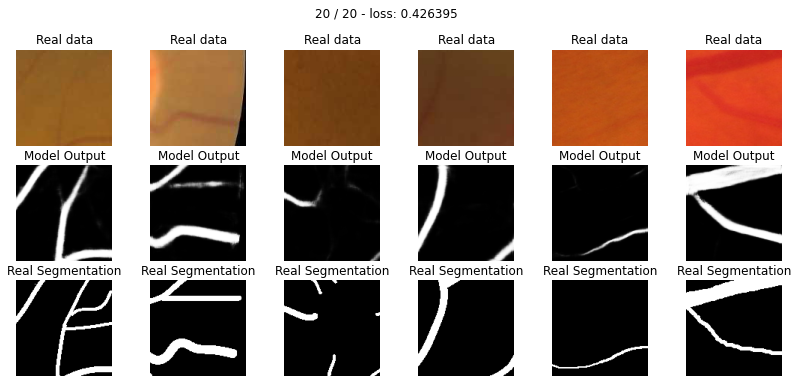

INFO: Early stopping counter 2 of 5


In [8]:
train_dict, val_dict = train(model,config,train_loader,val_loader,plotting=True)

### Performance on test set

In [9]:
test_dict = test(model, test_loader, config)

Testing : 100%|████████████████████████████████| 54/54 [00:04<00:00, 10.95it/s]


In [10]:
print(test_dict)

{'loss': 0.46053833762804663, 'metrics': array([0.7287, 0.5755, 0.9314, 0.7337, 0.9602])}


### Test equivariance

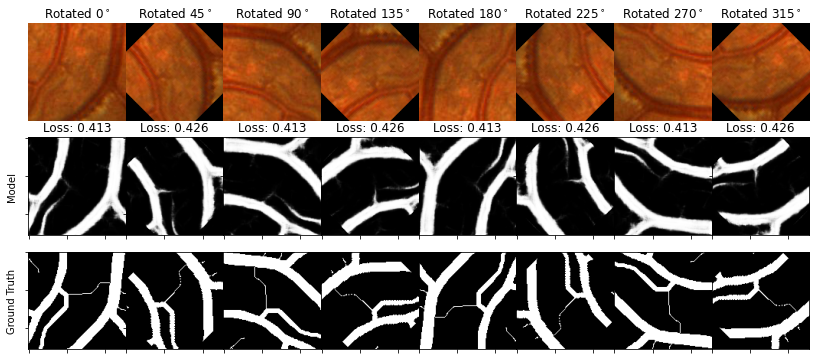

In [11]:
# Which image in the test set to visualize
idx = 4

# Which group to check invariance with respect to
group = "D8"

f,ax = visualize_test_equivariance(model, test_loader, config, idx = idx, group = group)
plt.show()

The model is not perfectly rotation equivariant due to the lack of the equivariant_mask. However we observe a much more consistent performance for rotations than the normal UNet counterpart.

In [12]:
equivariance_dict = test_equivariance(model, test_loader, config, group)

Testing: 100%|█████████████████████████████████| 54/54 [00:33<00:00,  1.62it/s]


In [13]:
equivariance_dict

{'loss': tensor([0.4605, 0.4468, 0.4605, 0.4468, 0.4605, 0.4468, 0.4605, 0.4468]),
 'metrics': tensor([[0.7287, 0.5755, 0.9314, 0.7337, 0.9602],
         [0.7172, 0.5616, 0.9414, 0.7196, 0.9674],
         [0.7287, 0.5755, 0.9314, 0.7337, 0.9602],
         [0.7172, 0.5616, 0.9414, 0.7196, 0.9674],
         [0.7287, 0.5755, 0.9314, 0.7337, 0.9602],
         [0.7172, 0.5616, 0.9414, 0.7196, 0.9674],
         [0.7287, 0.5755, 0.9314, 0.7337, 0.9602],
         [0.7172, 0.5616, 0.9414, 0.7196, 0.9674]]),
 'rotations': [0, 45, 90, 135, 180, 225, 270, 315]}

### Save model

In [14]:
#model_path = "saved_models/"
#model_name = "G-UNet"
#torch.save(model.state_dict(), model_path + model_name)
## Save dicts
#with open(model_path + model_name + ".pkl", 'wb') as f:
#    pickle.dump([config, train_dict, val_dict, test_dict], f)